# Fit weighted histograms with SPD method

[Bohm and Zech (2014)](https://arxiv.org/abs/1309.1287) derived an approximate log-likelihood for weighted histograms with on average positive weights.

The authors show that their approximation approaches the unbiased asymptotic limit in finite samples faster than the normal approximation. We test this here with a common HEP fit of a peak above a smooth background (here exponential).

The fits turn out to be biased for the tested weight distributions (normal, exponential, uniform). The largest bias is found for exponentially distributed weights with deviations of 4-5% in the fitted parameters. 

The bias originates from the fact that a plug-in estimate of the weight variance is used for each bin, which is inaccurate in bins with small number of samples. Empty bins cannot be handled by the method.

In [43]:
#!pip install boost-histogram iminuit scipy matplotlib numpy numba progressbar2
import boost_histogram as bh
from iminuit import Minuit
from scipy.stats import norm, expon, uniform, poisson
from matplotlib import pyplot as plt
import numpy as np
import numba as nb
from progressbar import progressbar
import sys

In [47]:
@nb.vectorize
def log_spd(w, wvar, expected):
    # Bohm and Zech, NIMA 748 (2014) 1-6
    if wvar > 0.0:
        s_inv = w / wvar
        mu = expected * s_inv
        n = w * s_inv
        return mu - n * np.log(mu)
    else:
        return 0.0


weight_distributions = [np.ones, norm(1, 0.1).rvs, expon().rvs, uniform(0, 2).rvs]

nmc = 10000
mu_npts = 1000
signal_fraction = 0.2

truth = ((1.0 - signal_fraction), signal_fraction, 1.0, 2.0, 0.2)

pars = []
for wd in weight_distributions:
    np.random.seed(1)
    sub_pars = []
    sys.stdout.flush()
    for imc in progressbar(range(nmc)):
        # sample total number of points from poisson distribution
        npts = poisson(mu_npts).rvs()
        
        # generate background
        b = expon(scale=truth[2]).rvs(int(truth[0] * npts))
        
        # generate signal
        s = norm(truth[3], truth[4]).rvs(int(truth[1] * npts))
        x = np.append(b, s)

        # generate weights
        wi = wd(len(x))

        h = bh.Histogram(bh.axis.Regular(20, 0, 3), storage=bh.storage.Weight())
        h.fill(x, weight=wi)
        xe = h.axes[0].edges
        w = h.view()

        def nll(par):
            bkg = expon(scale=par[2]).cdf(xe)
            sig = norm(par[3], par[4]).cdf(xe)
            mu_bkg = par[0] * npts * (bkg[1:] - bkg[:-1])
            mu_sig = par[1] * npts * (sig[1:] - sig[:-1])
            res = 2 * np.sum(log_spd(w.value, w.variance, mu_bkg + mu_sig))
            return res

        m = Minuit.from_array_func(
            nll,
            truth,
            limit=((0.0, None), (0.0, None), (0.0, None), None, (0.0, None)),
            pedantic=False,
        )
        m

        m.migrad()
        assert m.migrad_ok()
        sub_pars.append(m.np_values())
        
    pars.append(np.transpose(sub_pars))

100% (10000 of 10000) |##################| Elapsed Time: 0:25:12 Time:  0:25:12
100% (10000 of 10000) |##################| Elapsed Time: 0:22:23 Time:  0:22:23
100% (10000 of 10000) |##################| Elapsed Time: 0:22:22 Time:  0:22:22
100% (10000 of 10000) |##################| Elapsed Time: 0:21:48 Time:  0:21:48


parameter 0
  w=1             0.8 0.7981 +/- 0.0003 -0.2% -7.1s
  norm(1, 0.1)    0.8 0.7987 +/- 0.0003 -0.2% -4.9s
  expon           0.8 0.7702 +/- 0.0005 -3.7% -59.0s
  uniform(0, 2)   0.8 0.7923 +/- 0.0004 -1.0% -21.2s
parameter 1
  w=1             0.2 0.2012 +/- 0.0002 0.6% 7.0s
  norm(1, 0.1)    0.2 0.2008 +/- 0.0002 0.4% 4.3s
  expon           0.2 0.2077 +/- 0.0003 3.9% 24.7s
  uniform(0, 2)   0.2 0.2032 +/- 0.0002 1.6% 13.9s
parameter 2
  w=1             1.0 0.9978 +/- 0.0007 -0.2% -3.0s
  norm(1, 0.1)    1.0 0.9992 +/- 0.0007 -0.1% -1.1s
  expon           1.0 0.9531 +/- 0.0011 -4.7% -41.8s
  uniform(0, 2)   1.0 0.9874 +/- 0.0009 -1.3% -14.3s
parameter 3
  w=1             2.0 1.9994 +/- 0.0002 -0.0% -2.5s
  norm(1, 0.1)    2.0 1.9996 +/- 0.0002 -0.0% -1.8s
  expon           2.0 1.9967 +/- 0.0003 -0.2% -10.3s
  uniform(0, 2)   2.0 1.9986 +/- 0.0003 -0.1% -5.5s
parameter 4
  w=1             0.2 0.2001 +/- 0.0002 0.1% 0.6s
  norm(1, 0.1)    0.2 0.1997 +/- 0.0002 -0.2% -1.4s
  expon

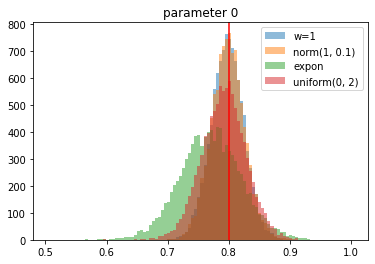

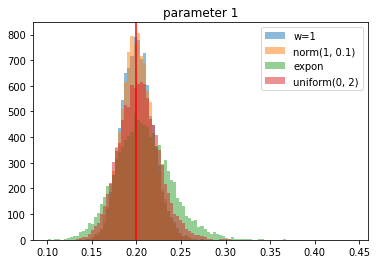

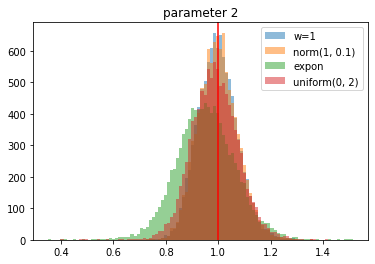

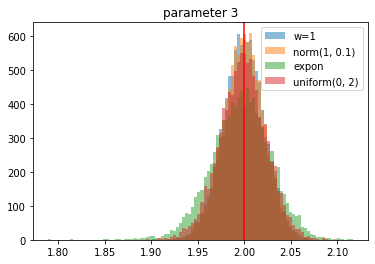

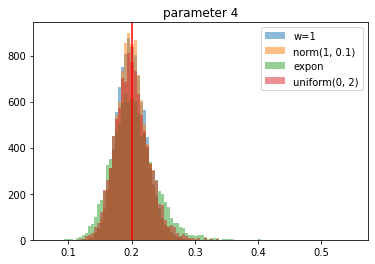

In [48]:
wd_labels = ("w=1", "norm(1, 0.1)", "expon", "uniform(0, 2)")
pars_range = np.transpose((np.min(pars, axis=(0, 2)), np.max(pars, axis=(0, 2))))
for ipar, t in enumerate(truth):
    plt.figure()
    plt.title(f"parameter {ipar}")
    plt.axvline(t, color="r")
    print(f"parameter {ipar}")
    for label, sub_pars in zip(wd_labels, pars):
        p = sub_pars[ipar]
        plt.hist(p, alpha=0.5, label=label, bins=100, range=pars_range[ipar])
        mean = np.mean(p)
        sigma = np.std(p) / len(p) ** 0.5
        print(f"  {label:15}", t, f"{mean:.4f} +/- {sigma:.4f} {(mean/t - 1)*1e2:.1f}% {(mean - t)/sigma:.1f}s")
    plt.legend()